In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd MyDrive

/gdrive/MyDrive


In [ ]:
!ls

'Colab Notebooks'   path   Simulator


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import torch
import pandas as pd
import torchvision
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Simulator/C_Difficult2_noise02.mat')

In [ ]:
spike_class = data['spike_class'][0][:]
spike_data = data['data']
spike_times = data['spike_times']

In [ ]:
idx_spike=spike_times
num_spike=len(spike_times)

In [ ]:
num_sample_forward=50
num_sample_backward=0
spike_curve=np.zeros((num_spike,num_sample_forward-num_sample_backward))
for i in range(num_spike):
    spike_curve[i]=spike_data[(idx_spike[i]+num_sample_backward):(idx_spike[i]+num_sample_forward)]

In [ ]:
# plt.figure(figsize=(20,10))
# for i in range(num_spike):
#     plt.plot(spike_curve[i],linewidth=0.4)
# plt.xticks(fontsize=8)
# plt.xlabel('sample',color='red')
# plt.ylabel('uV',color='red')

In [ ]:
scales = np.arange(1, 51)

In [ ]:
wavelet = np.zeros((len(spike_curve), 3, 50, 50))
for i in range(len(spike_curve)):
    # Compute CWT coefficients for Morlet wavelet
    cwtmatr = signal.cwt(spike_curve[i], signal.morlet, scales)
    wavelet[i, 0, :, :] = cwtmatr

    # Compute CWT coefficients for Ricker wavelet
    cwtmatr = signal.cwt(spike_curve[i], signal.ricker, scales)
    wavelet[i, 1, :, :] = cwtmatr

    # Compute CWT coefficients for other wavelet family (replace with desired wavelet family)
    cwtmatr = signal.cwt(spike_curve[i], signal.gaussian, scales)
    wavelet[i, 2, :, :] = cwtmatr



<ipython-input-11-359e8972b0bc>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  wavelet[i, 0, :, :] = cwtmatr


In [ ]:
# from scipy import ndimage
# resized_wavelet = np.zeros((len(spike_curve), 3, 224, 224))
# for i in range(len(spike_curve)):
#     for j in range(3):
#         resized_wavelet[i, j, :, :] = ndimage.zoom(wavelet[i, j, :, :], (224/50, 224/50))

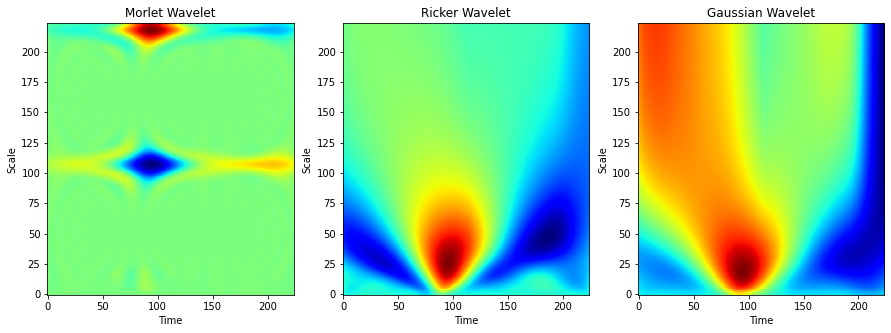

In [ ]:
spk = 56
# Get the CWT coefficients for the first spike curve for all three wavelets
morlet_coeffs =  resized_wavelet[spk, 0, :, :]
ricker_coeffs =  resized_wavelet[spk, 1, :, :]
gaussian_coeffs =resized_wavelet[spk, 2, :, :]

# Plot the scalograms for all three wavelets
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(morlet_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[0].set_title('Morlet Wavelet')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Scale')

axs[1].imshow(ricker_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Ricker Wavelet')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Scale')

axs[2].imshow(gaussian_coeffs, aspect='auto', cmap='jet', origin='lower')
axs[2].set_title('Gaussian Wavelet')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Scale')

plt.show()


In [ ]:
import torchvision.models as models

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # Load the VGG model
        self.vgg = models.vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        for param in self.vgg.classifier[-1].parameters():
            param.requires_grad = True
        # Replace the last layer with a new layer with 3 output features
        num_features = self.vgg.classifier[-1].in_features
        self.vgg.classifier[-1] = nn.Linear(num_features, 3)
        # Add a softmax layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass the input through the VGG model
        x = self.vgg(x)
        # Pass the output through the softmax layer
        x = self.softmax(x)
        return x

In [ ]:
# Define your execution device
model = VGG16()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n")
model.to(device)    # Convert model parameters and buffers to CPU or Cuda
#summary(model, (3, 224, 224))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

The model will be running on cuda:0 device



VGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Load your data and labels
label = spike_class-1
data =  resized_wavelet
mean = np.mean(data)
std = np.std(data)
data = (data - mean) / std


X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.50,stratify=label,shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(X_train, X_label, test_size=0.05,stratify=X_label,shuffle = True)

# Convert the data and labels to PyTorch tensors
train_inputs = torch.from_numpy(train_data).float()
val_inputs = torch.from_numpy(val_data).float()
test_inputs = torch.from_numpy(test_data).float()

train_labels = torch.from_numpy(train_label).float()
val_labels = torch.from_numpy(val_label).float()
test_labels = torch.from_numpy(test_label).float()



In [ ]:
print(train_inputs.shape)
print(val_inputs.shape)
print(test_inputs.shape)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

In [ ]:
num_epochs = 20

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.01,weight_decay=0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.01)
optimizer = optim.ASGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)


inputs = torch.tensor([])
# Train the network
for epoch in range(num_epochs):
  training_loss = 0
  loss_back = 0
  for i in range(0, train_inputs.size(0)):
    # Get the input and labels for the current batch
    inputs = train_inputs[i:i+1].to(device)
    labels = train_labels[i:i+1].to(device)
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.long())
    training_loss += loss
    loss_back += loss
    if i % 10 == 0:
        optimizer.zero_grad()
        # Backward pass and optimization
        loss_back.backward()
        optimizer.step()
        loss_back = 0
  training_loss = training_loss/train_inputs.size(0)
  print('******************************************************************')
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))
  with torch.no_grad():
          correct = 0
          val_loss = 0
          for j in range(0,val_inputs.size(0)):
            # Get the input and labels for the current batch
            inputs = val_inputs[j:j+1].to(device)
            labels = val_labels[j:j+1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += loss
          val_loss = val_loss/val_inputs.size(0)
          print('Validation Loss: {:.4f}'.format(val_loss))
          print('Validation Accuracy: {:.2f}% ({}/{})'.format(100*correct/val_inputs.size(0), correct, val_inputs.size(0)))

# Test the network on the test set
with torch.no_grad():
  test_loss = 0
  correct = 0
  total = 0
  for i in range(0, test_inputs.size(0)):
        # Get the input and labels for the current batch
        inputs = test_inputs[i:i+1].to(device)
        labels = test_labels[i:i+1].to(device)
        outputs = model(inputs)
        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels.long())
        test_loss += loss

print('Test Loss: {:.4f}'.format(test_loss/test_inputs.size(0)))
print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)))




In [ ]:
with torch.no_grad():
  test_loss = 0
  correct = 0
  total = 0
  for i in range(0, test_inputs.size(0)):
        # Get the input and labels for the current batch
        inputs = test_inputs[i:i+1].to(device)
        labels = test_labels[i:i+1].to(device)
        outputs = model(inputs)
        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels.long())
        test_loss += loss

print('Test Loss: {:.4f}'.format(test_loss/test_inputs.size(0)))
print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)))

